<a href="https://colab.research.google.com/github/mostafa-ja/graph-tutorial/blob/master/Illegal_Bitcoin_Transactions2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [1]:
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 11.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=d74a427051b4ed3ed0d4f7c3e5076f2071dd39f1b4220ebe17cdbae9d2a0e9cc
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric


In [2]:
import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import numpy as np 
import pandas as pd 
import torch 
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

#Import data from kaggle

1.Go to “Account”, go down the page, and find the “API” section.Click the “Create New API Token” button.The “kaggle.json” file will be downloaded.

2 . Upload it in the current directory

In [3]:
# 3.Install Kaggle API.
!pip install kaggle
# 4.Run the following code to configure the path to “kaggle.json”
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# 5.download dataset from kaggle
!kaggle datasets download -d ellipticco/elliptic-data-set
!unzip elliptic-data-set.zip

 99% 145M/146M [00:00<00:00, 194MB/s]
100% 146M/146M [00:00<00:00, 178MB/s]
Archive:  elliptic-data-set.zip
  inflating: elliptic_bitcoin_dataset/elliptic_txs_classes.csv  
  inflating: elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv  
  inflating: elliptic_bitcoin_dataset/elliptic_txs_features.csv  


#Transaction data

In [5]:
path = '/content'
df_edges = pd.read_csv(path + "/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
df_classes = pd.read_csv(path + "/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
df_features = pd.read_csv(path + "/elliptic_bitcoin_dataset/elliptic_txs_features.csv", header=None)

# rename the classes to ints that can be handled by pytorch as labels
df_classes["label"] = df_classes["class"].replace(
    {"unknown": -1,  # unlabeled nodes
     "2": 0,  # labeled licit nodes
     #"1": 1,  # labeled illicit nodes
    }
).astype(int)

# rename features according to data description in paper
rename_dict = dict(
    zip(
        range(0, 167),
        ["txId", "time_step"]
        + [f"local_{i:02d}" for i in range(1, 94)]
        + [f"aggr_{i:02d}" for i in range(1, 73)],
    )
)
df_features.rename(columns=rename_dict, inplace=True)

In [6]:
df_features.head()

txId  time_step  local_01  local_02  local_03   local_04  local_05  \
0  230425980          1 -0.171469 -0.184668 -1.201369  -0.121970 -0.043875   
1    5530458          1 -0.171484 -0.184668 -1.201369  -0.121970 -0.043875   
2  232022460          1 -0.172107 -0.184668 -1.201369  -0.121970 -0.043875   
3  232438397          1  0.163054  1.963790 -0.646376  12.409294 -0.063725   
4  230460314          1  1.011523 -0.081127 -1.201369   1.153668  0.333276   

   local_06   local_07  local_08  ...   aggr_63   aggr_64   aggr_65   aggr_66  \
0 -0.113002  -0.061584 -0.162097  ... -0.562153 -0.600999  1.461330  1.461369   
1 -0.113002  -0.061584 -0.162112  ...  0.947382  0.673103 -0.979074 -0.978556   
2 -0.113002  -0.061584 -0.162749  ...  0.670883  0.439728 -0.979074 -0.978556   
3  9.782742  12.414558 -0.163645  ... -0.577099 -0.613614  0.241128  0.241406   
4  1.312656  -0.061584 -0.163523  ... -0.511871 -0.400422  0.517257  0.579382   

    aggr_67   aggr_68   aggr_69   aggr_70   aggr_71   aggr_72  
0  0.018279 -0.087490 -0.131155 -0.097524 -0.120613 -0.119792  
1  0.018279 -0.087490 -0.131155 -0.097524 -0.120613 -0.119792  
2 -0.098889 -0.106715 -0.131155 -0.183671 -0.120613 -0.119792  
3  1.072793  0.085530 -0.131155  0.677799 -0.120613 -0.119792  
4  0.018279  0.277775  0.326394  1.293750  0.178136  0.179117  

[5 rows x 167 columns]

In [8]:
df_edges.head()

txId1      txId2
0  230425980    5530458
1  232022460  232438397
2  230460314  230459870
3  230333930  230595899
4  232013274  232029206

In [9]:
df_classes.head()

txId    class  label
0  230425980  unknown     -1
1    5530458  unknown     -1
2  232022460  unknown     -1
3  232438397        2      0
4  230460314  unknown     -1

In [10]:
print(f"Number of missing data points: {df_features.isna().sum().sum()+df_classes.isna().sum().sum()}")
print(f"Number of nodes (transactions): {df_features['txId'].nunique()}") #nunique() method returns the number of unique values for each column
print(f"Number of edges: {df_edges.shape[0]}")
print(f"Number of classes: {df_classes['class'].nunique()}")
print(f"Timesteps range from {df_features['time_step'].min()} to {df_features['time_step'].max()}")

Number of missing data points: 0
Number of nodes (transactions): 203769
Number of edges: 234355
Number of classes: 3
Timesteps range from 1 to 49


In [ ]:
g_nx = nx.MultiDiGraph()  # A directed graph class that can store multiedges, Self loops are allowed
g_nx.add_nodes_from(
    zip(df_classes["txId"], [{"label": v} for v in df_classes["label"]])
)
g_nx.add_edges_from(zip(df_edges["txId1"], df_edges["txId2"]));

In [ ]:
print(f"Graph with {g_nx.number_of_nodes()} nodes and {g_nx.number_of_edges()} edges.")
print(f"Number of connected components: {len(list(nx.weakly_connected_components(g_nx)))}")

Graph with 203769 nodes and 234355 edges.
Number of connected components: 49


In [ ]:
components = list(nx.weakly_connected_components(g_nx))
g_nx_t_list = [g_nx.subgraph(components[i]) for i in range(0,len(components))]

<ipython-input-34-9f3c0101590e>:9: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color('grey')
<ipython-input-34-9f3c0101590e>:10: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color('C0')
<ipython-input-34-9f3c0101590e>:11: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[2].set_color('C3')
<ipython-input-34-9f3c0101590e>:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


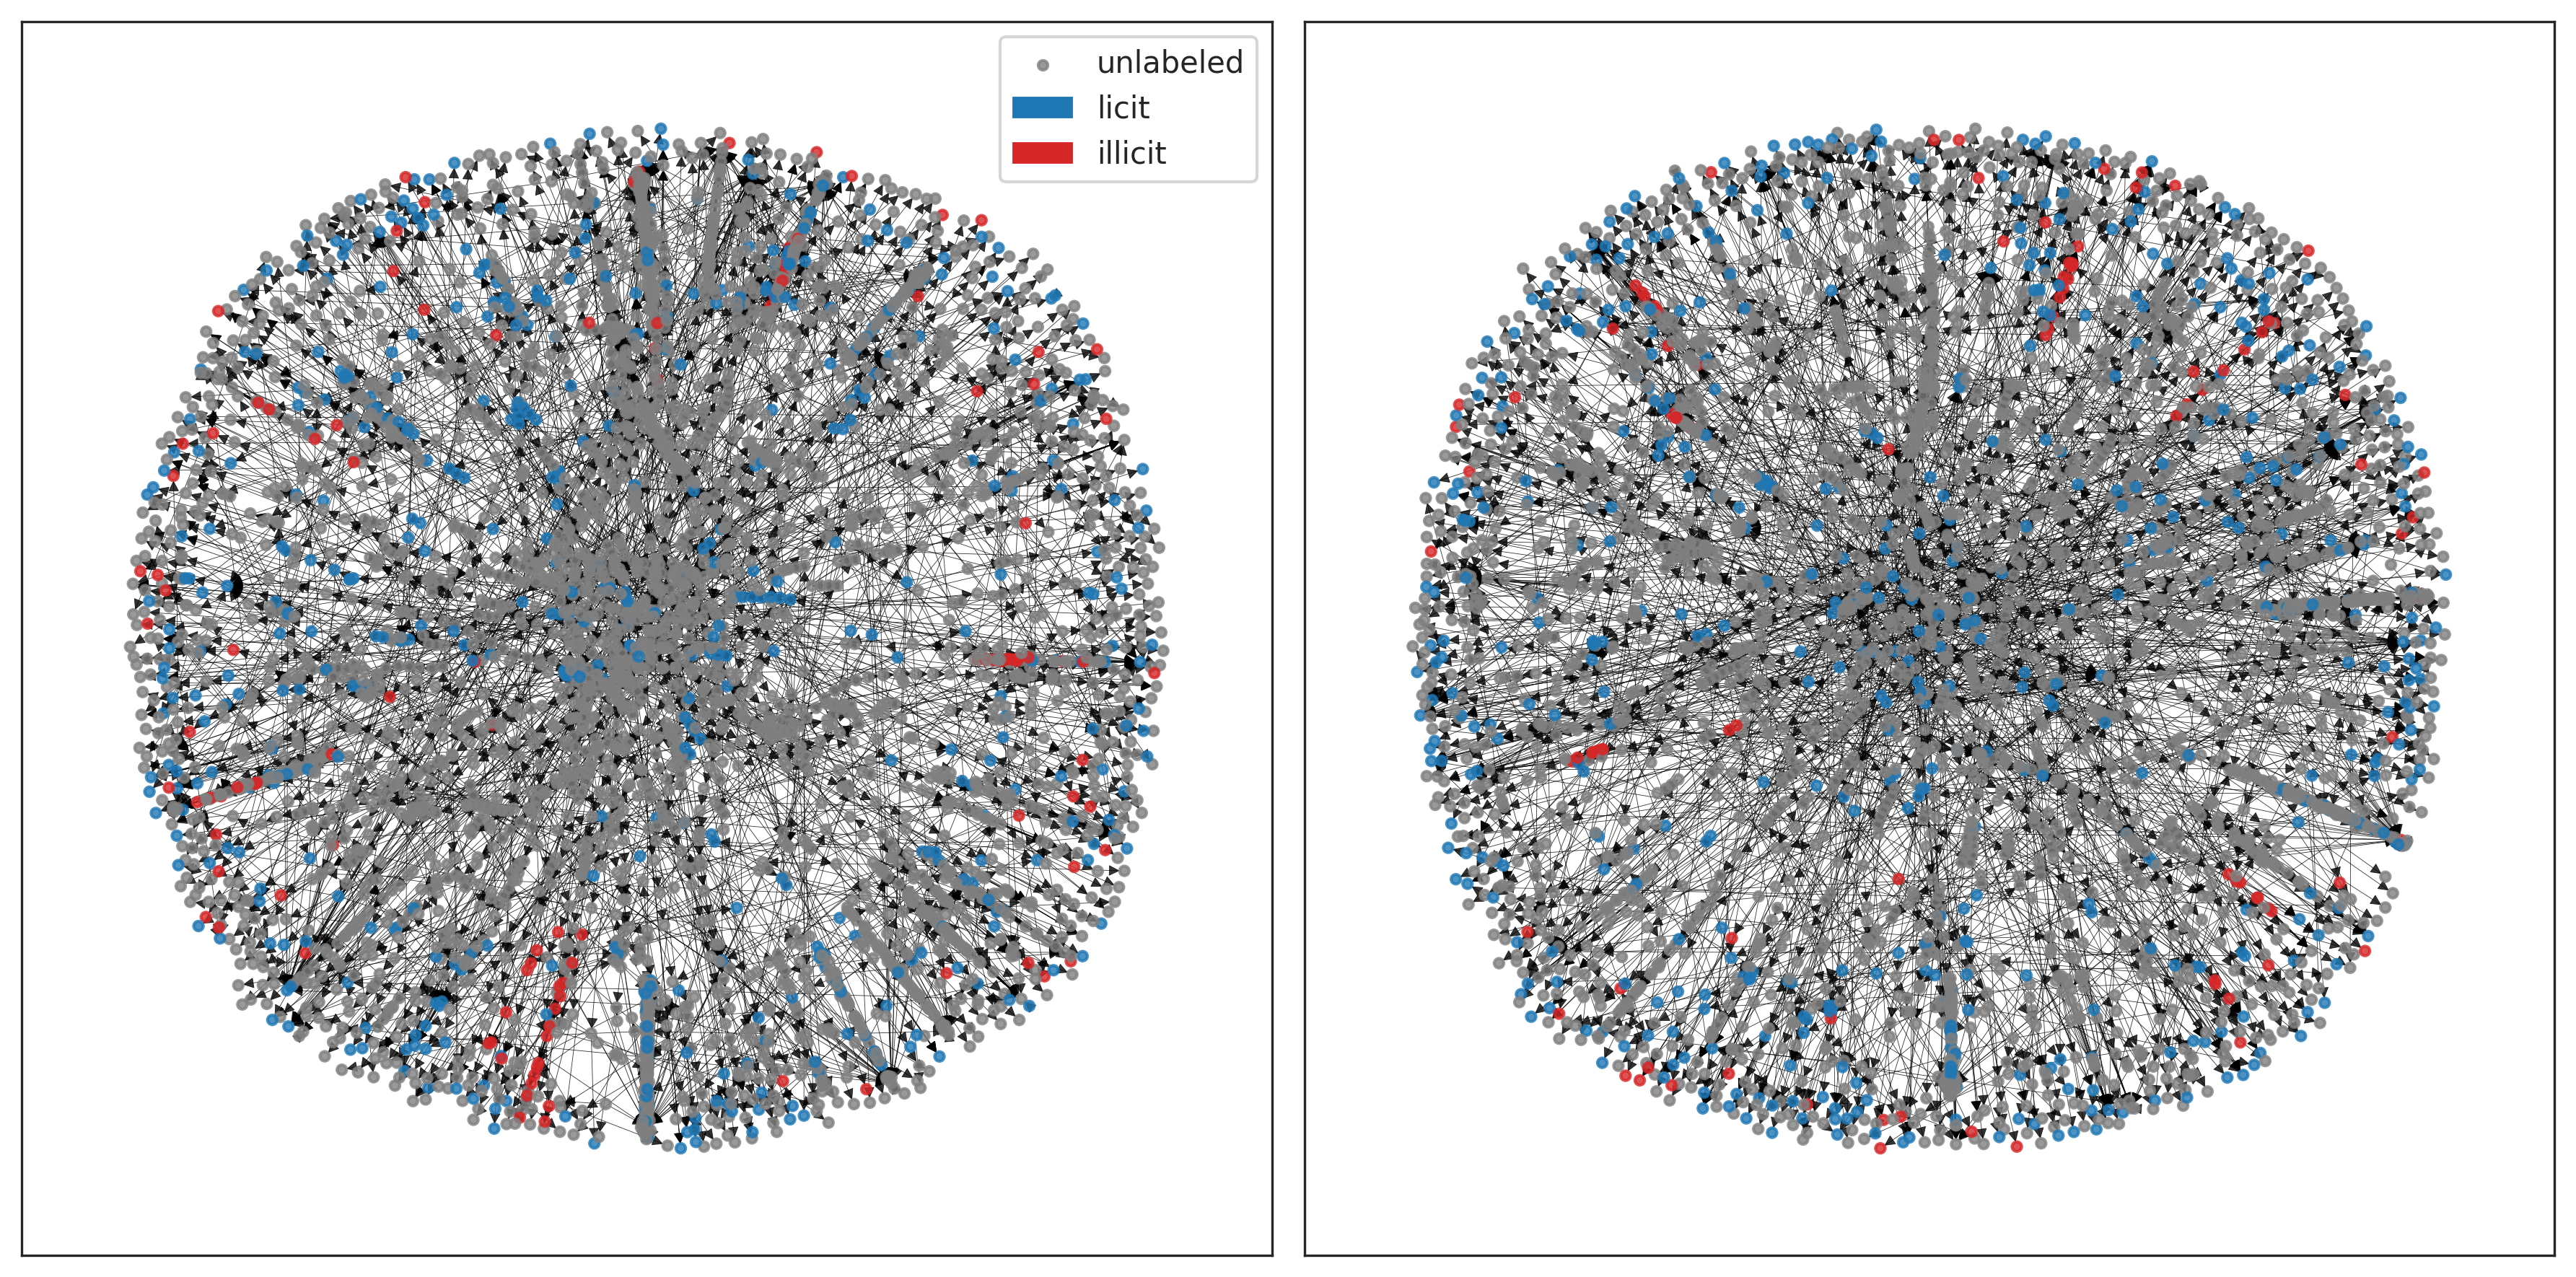

In [ ]:
with sns.axes_style('white'):
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    for i,t in enumerate([10,20]):
        node_label = list(nx.get_node_attributes(g_nx_t_list[t], 'label').values())
        mapping = {-1:'grey', 0:'C0', 1:'C3'}
        node_color = [mapping[l] for l in node_label]
        nx.draw_networkx(g_nx_t_list[t], node_size=10, node_color=node_color, with_labels=False, width=0.2, alpha=0.8, arrowsize=8, ax=ax[i])
    leg = ax[0].legend(['unlabeled', 'licit', 'illicit'])
    leg.legendHandles[0].set_color('grey')
    leg.legendHandles[1].set_color('C0')
    leg.legendHandles[2].set_color('C3')
    plt.tight_layout()

In [ ]:
g_metrics = {}
g_metrics['timestep'] = np.arange(1,50)
g_metrics['number_of_nodes'] = [graph.number_of_nodes() for graph in g_nx_t_list]
g_metrics['avg_degree'] = [np.mean(list(dict(nx.degree(graph)).values())) for graph in g_nx_t_list]
g_metrics['density'] = [nx.density(graph) for graph in g_nx_t_list]
g_metrics['avg_clustering'] = [nx.average_clustering(nx.DiGraph(graph)) for graph in g_nx_t_list]

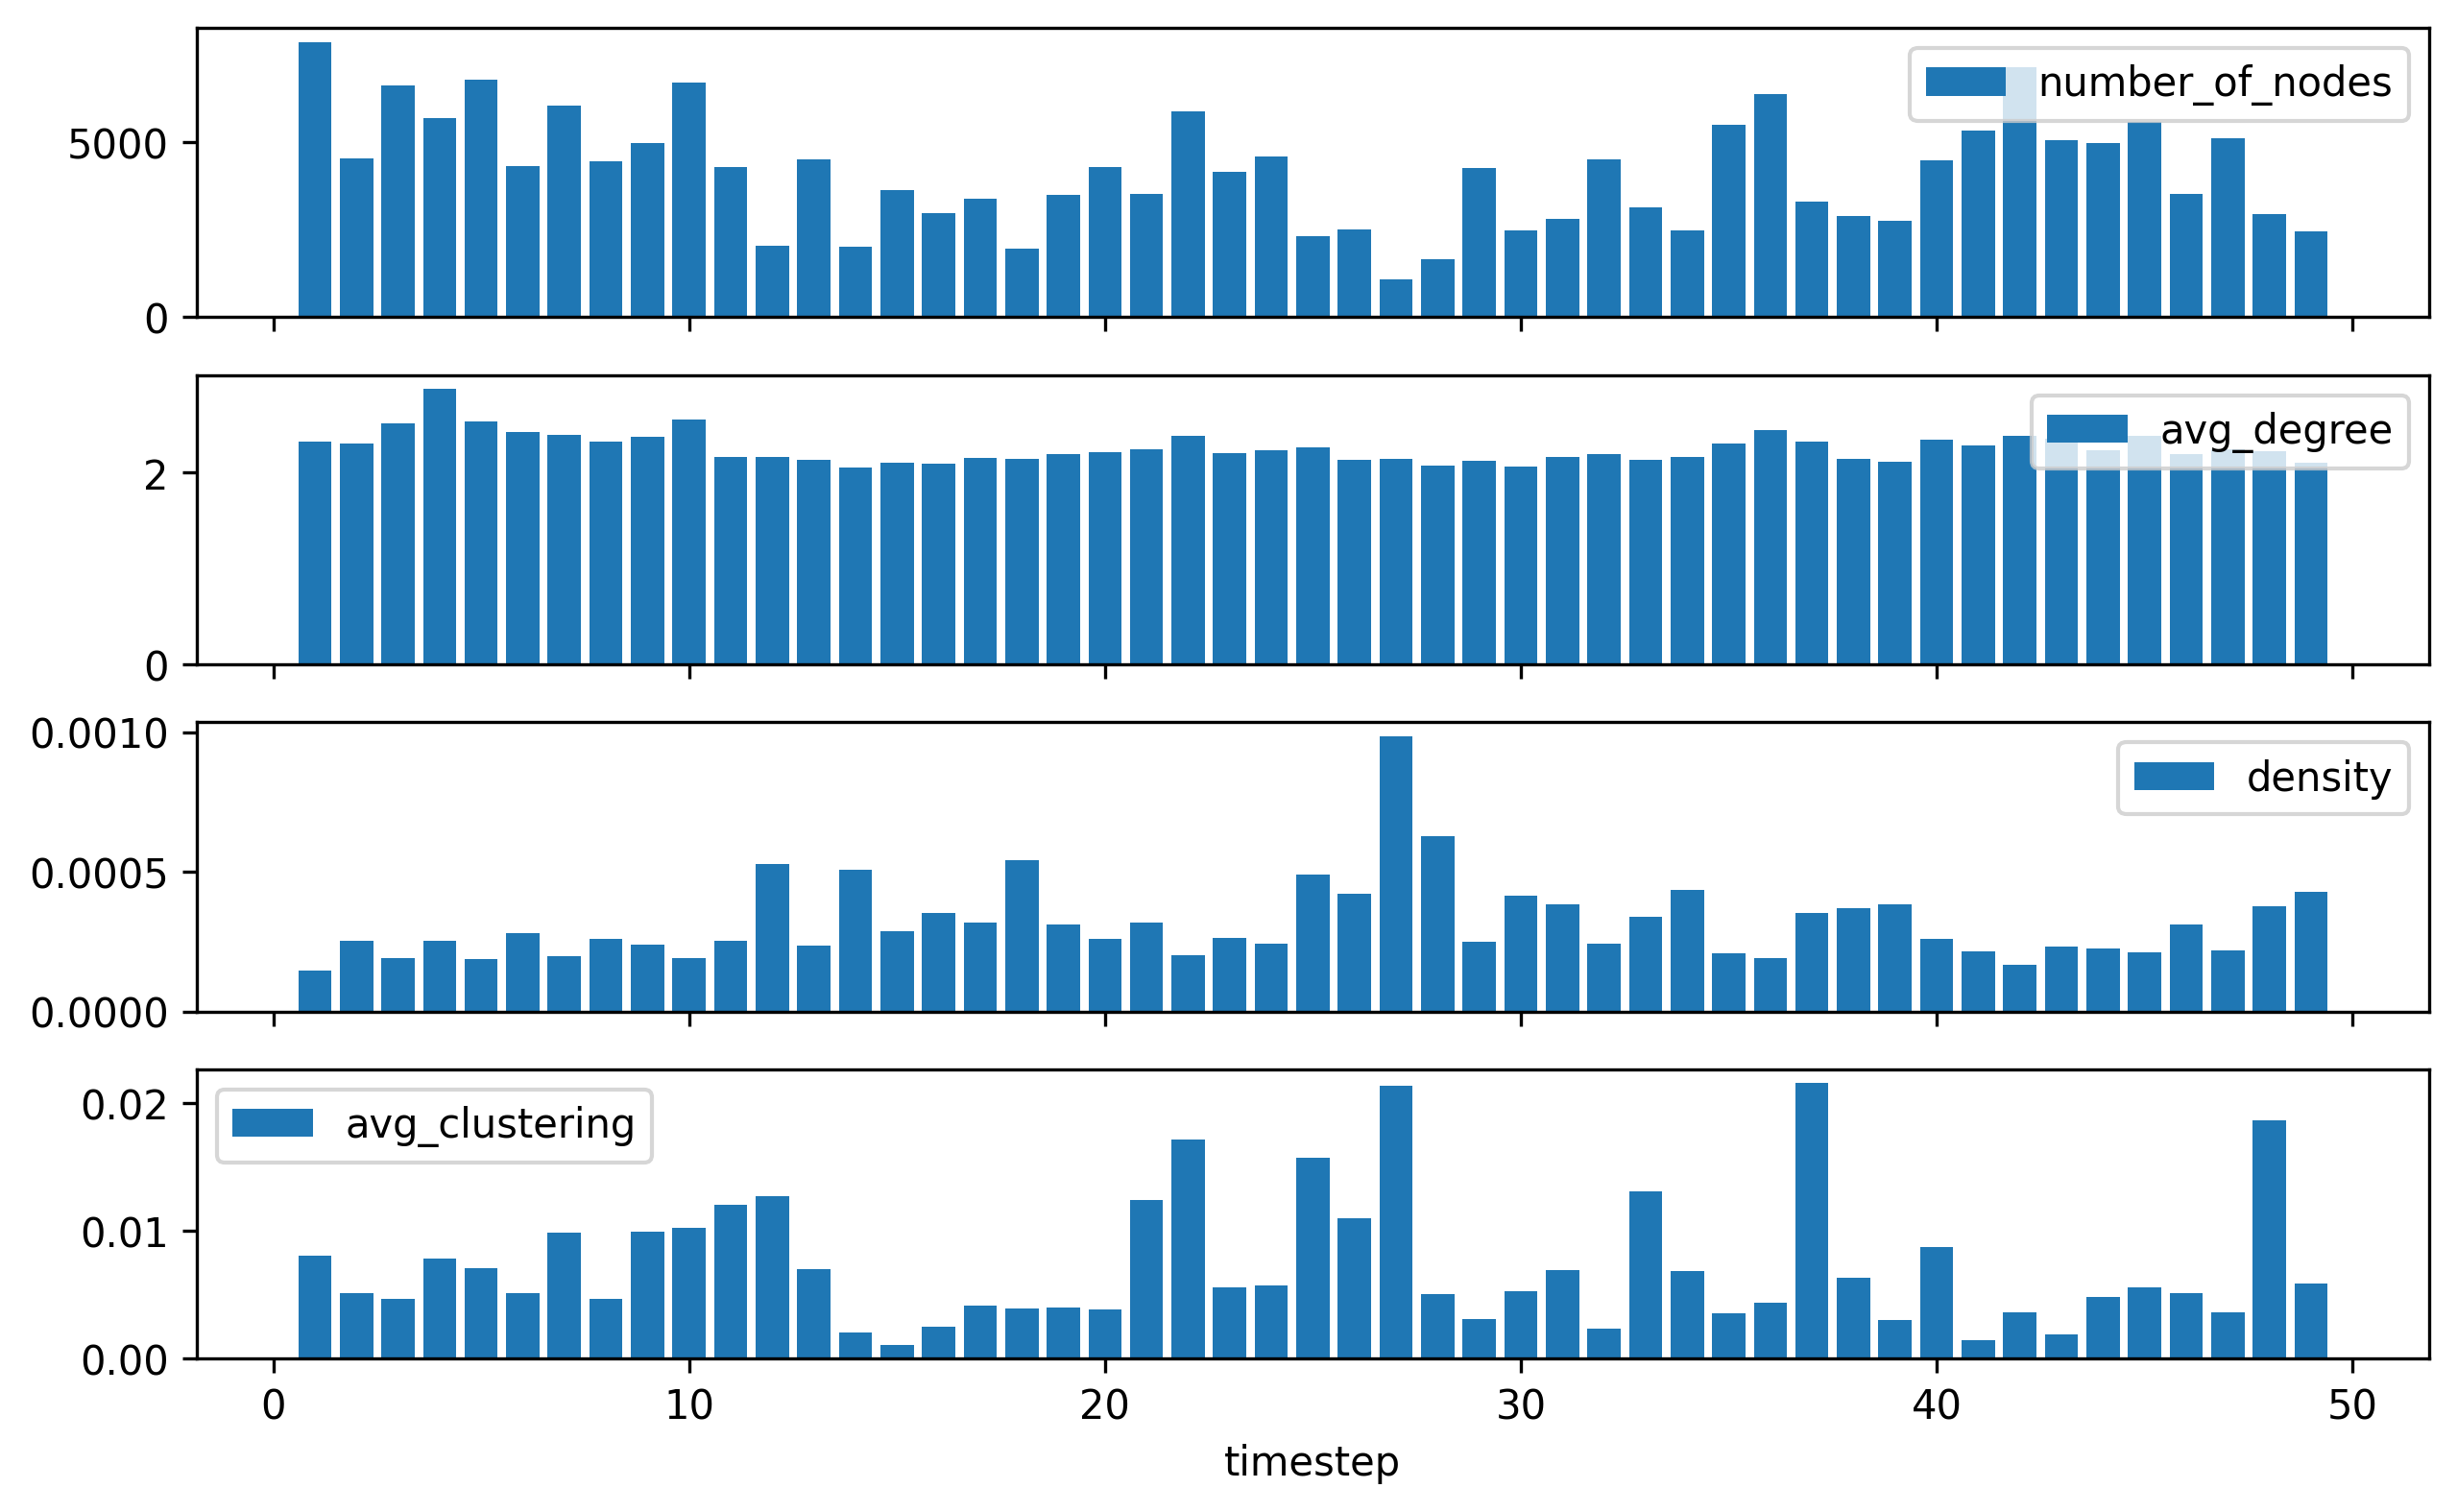

In [ ]:
fig, ax = plt.subplots(len(g_metrics)-1,1, figsize=(10,6), sharex=True)
for i,label in enumerate(list(g_metrics.keys())[1:]):
    ax[i].bar(g_metrics['timestep'], g_metrics[label], label=label)
    ax[i].legend()
plt.xlabel('timestep');

In [ ]:
print(f"Average density of the graphs across all timesteps: {np.mean(g_metrics['density']):.6f}")
print(f"Average degree of all nodes across all timesteps: {np.mean(list(dict(nx.degree(g_nx)).values())):.2f}")

Average density of the graphs across all timesteps: 0.000318
Average degree of all nodes across all timesteps: 2.30


In [ ]:
df_classes.head()

txId    class  label
0  230425980  unknown     -1
1    5530458  unknown     -1
2  232022460  unknown     -1
3  232438397        2      0
4  230460314  unknown     -1

In [ ]:
df_classes.set_index("txId") # make the first column as index of the table

class  label
txId                     
230425980  unknown     -1
5530458    unknown     -1
232022460  unknown     -1
232438397        2      0
230460314  unknown     -1
...            ...    ...
173077460  unknown     -1
158577750  unknown     -1
158375402        1      1
158654197  unknown     -1
157597225  unknown     -1

[203769 rows x 2 columns]

In [ ]:
df_classes.set_index("txId").loc[sorted(g_nx.nodes()), "label"] # just "lable" column

txId
1076        -1
2534         0
3181         0
3321        -1
3889        -1
            ..
403203785   -1
403234712   -1
403234715   -1
403235564   -1
403244581   -1
Name: label, Length: 203769, dtype: int64

In [ ]:
g = dgl.from_networkx(g_nx)
g.ndata["label"] = torch.tensor(
    df_classes.set_index("txId").loc[sorted(g_nx.nodes()), "label"].values
)
g.ndata["features_matrix"] = torch.tensor(
    df_features.set_index("txId").loc[sorted(g_nx.nodes()), :].values
)
print(g)

Graph(num_nodes=203769, num_edges=234355,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'features_matrix': Scheme(shape=(166,), dtype=torch.float64)}
      edata_schemes={})


In [ ]:
g_nx_bidirectional = g_nx.to_undirected().to_directed()

# create bidirectional graph
g_bi = dgl.from_networkx(g_nx_bidirectional)
g_bi.ndata["label"] = torch.tensor(
    df_classes.set_index("txId").loc[sorted(g_nx.nodes()), "label"].values
)
g_bi.ndata["features_matrix"] = torch.tensor(
    df_features.set_index("txId").loc[sorted(g_nx.nodes()), :].values
)
print(g_bi)

Graph(num_nodes=203769, num_edges=468710,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'features_matrix': Scheme(shape=(166,), dtype=torch.float64)}
      edata_schemes={})


In [ ]:
g.add_edges(g.nodes(), g.nodes())
print(g)

# add self loop to the bidirectional edges graph
g_bi.add_edges(g_bi.nodes(), g_bi.nodes())
print(g_bi)

Graph(num_nodes=203769, num_edges=438124,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'features_matrix': Scheme(shape=(166,), dtype=torch.float64)}
      edata_schemes={})
Graph(num_nodes=203769, num_edges=672479,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'features_matrix': Scheme(shape=(166,), dtype=torch.float64)}
      edata_schemes={})


In [ ]:
g.ndata.keys()

dict_keys(['label', 'features_matrix'])

In [ ]:
g.ndata["features_matrix"].shape

torch.Size([203769, 166])

In [ ]:
g.ndata["label"].shape

torch.Size([203769])

In [ ]:
df_classes["label"].notna() # non-missing values

0         True
1         True
2         True
3         True
4         True
          ... 
203764    True
203765    True
203766    True
203767    True
203768    True
Name: label, Length: 203769, dtype: bool

In [ ]:
features = g.ndata["features_matrix"].float()
labels = g.ndata["label"].long()  # format required for cross entropy loss
in_feats = features.shape[1]
n_classes = 2  # licit or illicit (unknown label is ignored)
n_edges = g.number_of_edges()

dataset_size = df_classes["label"].notna().sum()
train_ratio = 0.7
train_time_steps = round(len(np.unique(features[:, 0])) * train_ratio)  # features[:, 0] : timestep column
shutdown_timestep = 43
train_indices = (
    ((features[:, 0] <= train_time_steps) & (labels != -1)).nonzero().view(-1)
)
val_indices = (
    ((features[:, 0] > train_time_steps) & (labels != -1)).nonzero().view(-1)
)
# timestep_indices = {
#     t:(
#     ((features[:, 0] == t) & (labels != -1)).nonzero().view(-1)
# ) for t in range(train_time_steps+1,50)
# }

print(f"""Number of timesteps used for training: {train_time_steps}
Number of timesteps used for validation: {49-train_time_steps}""")

Number of timesteps used for training: 34
Number of timesteps used for validation: 15


In [ ]:
features = g.ndata["features_matrix"].float()
labels = g.ndata["label"].long()  # format required for cross entropy loss
in_feats = features.shape[1]
n_classes = 2  # licit or illicit (unknown label is ignored)
n_edges = g.number_of_edges()

In [ ]:
features[:, 0] : timestep column

tensor([48.,  6., 34.,  ..., 28., 28., 28.])

In [ ]:
((features[:, 0] <= train_time_steps) & (labels != -1)).nonzero().view(-1)

tensor([     1,      2,     41,  ..., 203727, 203743, 203750])

In [ ]:
class GCN(nn.Module):
    def __init__(
        self, g, in_feats, n_hidden, n_classes, n_layers, activation, dropout, bias
    ):
        super(GCN, self).__init__()
        self.g = g
        self.layers = nn.ModuleList()
        # input layer
        self.layers.append(
            GraphConv(in_feats, n_hidden, activation=activation, bias=bias)
        )
        # hidden layers
        for _ in range(n_layers - 2):
            self.layers.append(
                GraphConv(n_hidden, n_hidden, activation=activation, bias=bias)
            )
        # output layer
        self.layers.append(GraphConv(n_hidden, n_classes, bias=bias))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, features):
        h = features
        for i, layer in enumerate(self.layers):
            if i != 0:
                h = self.dropout(h)
            h = layer(self.g, h)
        return h


# utility function to evaluate the model
def evaluate(model, loss_fcn, features, labels, mask):
    """Calculate the loss, accuracy, precision, recall and f1_score for the masked data"""
    model.eval()
    with torch.no_grad():
        logits = model(features)
        logits = logits[mask]
        labels = labels[mask]
        loss = loss_fcn(logits, labels)
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        p, r, f, _ = precision_recall_fscore_support(labels, indices)
        return loss, correct.item() * 1.0 / len(labels), p[1], r[1], f[1]
    

# utility function to obtain a confusion matrix
def eval_confusion_matrix(model, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
    print(confusion_matrix(labels, indices))

In [ ]:
def train_eval_model(model_class, g, features, **params):
    
    #bidirectional = params["bidirectional"] if "bidirectional" in params else None
    in_feats = features.shape[1]
    n_classes = 2
    n_hidden = params["n_hidden"]
    n_layers = params["n_layers"]
    weight_decay = params["weight_decay"]
    bias = params["bias"]
    dropout = params["dropout"]
    epochs = params["epochs"]
    lr = params["lr"]
    posweight = params["posweight"]
    
    model = model_class(g, in_feats, n_hidden, n_classes, n_layers, F.relu, dropout, bias)

    # weighted cross entropy loss function
    loss_fcn = torch.nn.CrossEntropyLoss(
        weight=torch.tensor([1 - posweight, posweight])
    )

    # use optimizer
    optimizer = torch.optim.Adam(
        model.parameters(), lr=lr, weight_decay=weight_decay
    )

    dur = []
    metrics = {"loss":{"train": [], "val": []},
               "accuracy":{"train": [], "val": []},
               "precision":{"train": [], "val": []},
               "recall":{"train": [], "val": []},
               "f1_score":{"train": [], "val": []},
              }

    for epoch in range(epochs):
        model.train()
        if epoch >= 3:
            t0 = time.time()
        # forward pass
        logits = model(features)
        loss = loss_fcn(logits[train_indices], labels[train_indices])
        metrics["loss"]["train"].append(loss)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # duration
        if epoch >= 3:
            dur.append(time.time() - t0)
        # evaluate on training set
        _, train_acc, train_precision, train_recall, train_f1_score = evaluate(
            model, loss_fcn, features, labels, train_indices
        )
        metrics["accuracy"]["train"].append(train_acc)
        metrics["precision"]["train"].append(train_precision)
        metrics["recall"]["train"].append(train_recall)
        metrics["f1_score"]["train"].append(train_f1_score)
        # evaluate on validation set
        val_loss, val_acc, val_precision, val_recall, val_f1_score = evaluate(
            model, loss_fcn, features, labels, val_indices
        )
        metrics["loss"]["val"].append(val_loss)
        metrics["accuracy"]["val"].append(val_acc)
        metrics["precision"]["val"].append(val_precision)
        metrics["recall"]["val"].append(val_recall)
        metrics["f1_score"]["val"].append(val_f1_score)
        if (epoch + 1) % 100 == 0:
            print(
                f"Epoch {epoch:05d} | Time(s) {np.mean(dur):.2f} | val_loss {val_loss.item():.4f} "
                f"| Precision {val_precision:.4f} | Recall {val_recall:.4f} | Acc {val_acc:.4f} "
                f"| F1_score {val_f1_score:.4f}"
            )

    print("Confusion matrix:")
    eval_confusion_matrix(model, features, labels, val_indices)
    return model, metrics

In [ ]:
params = {
    "n_hidden" : 100,
    "n_layers" : 2,
    "weight_decay" : 0.,
    "bias" : False,
    "dropout" : 0.,
    "epochs" : 1000,
    "lr" : 1e-3,
    "posweight" : 0.7,
}

# train on graph with unidirectional edges
model, metrics = train_eval_model(GCN, g, features, **params)

/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 00099 | Time(s) 1.17 | val_loss 0.3575 | Precision 0.2564 | Recall 0.5282 | Acc 0.8698 | F1_score 0.3452
Epoch 00199 | Time(s) 1.14 | val_loss 0.3357 | Precision 0.3861 | Recall 0.4931 | Acc 0.9161 | F1_score 0.4331
Epoch 00299 | Time(s) 1.15 | val_loss 0.3217 | Precision 0.4438 | Recall 0.4737 | Acc 0.9272 | F1_score 0.4582
Epoch 00399 | Time(s) 1.14 | val_loss 0.3212 | Precision 0.5943 | Recall 0.4829 | Acc 0.9450 | F1_score 0.5329
Epoch 00499 | Time(s) 1.15 | val_loss 0.3539 | Precision 0.6192 | Recall 0.4700 | Acc 0.9468 | F1_score 0.5344
Epoch 00599 | Time(s) 1.17 | val_loss 0.3921 | Precision 0.6209 | Recall 0.4506 | Acc 0.9464 | F1_score 0.5222
Epoch 00699 | Time(s) 1.19 | val_loss 0.4336 | Precision 0.6070 | Recall 0.4294 | Acc 0.9449 | F1_score 0.5030
Epoch 00799 | Time(s) 1.21 | val_loss 0.4806 | Precision 0.5941 | Recall 0.4312 | Acc 0.9439 | F1_score 0.4997
Epoch 00899 | Time(s) 1.23 | val_loss 0.5211 | Precision 0.6092 | Recall 0.4303 | Acc 0.9451 | F1_score 0.5043
E

In [5]:

!pip install torch-geometric
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 26.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=667380cb788938ebef59c68acef0c35a25e322d69137c5101c7c25b2dec9904a
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.7 MB/s eta 0:00:00


In [6]:
import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import numpy as np 
import pandas as pd 
import torch 
import torch.nn.functional as F
import torch.optim as optim
import optuna
from optuna.trial import TrialState
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from google.colab import drive, files
import networkx as nx
import matplotlib.pyplot as plt

In [10]:
path = '/content'

edges = pd.read_csv(path + "/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
classes = pd.read_csv(path + "/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
features = pd.read_csv(path + "/elliptic_bitcoin_dataset/elliptic_txs_features.csv", header=None)

In [ ]:
classes.head()

In [11]:
classes["class"].replace(
    {"unknown": -1,  # unlabeled nodes
     "2": 0,  # labeled licit nodes
     #"1": 1,  # labeled illicit nodes
    }
).astype(int)


0        -1
1        -1
2        -1
3         0
4        -1
         ..
203764   -1
203765   -1
203766    1
203767   -1
203768   -1
Name: class, Length: 203769, dtype: int64

In [12]:
# remap class, licit: 0, illicit: 1, unknown: -1
classes["class"] = classes["class"].replace({"unknown": -1,  # unlabeled nodes
                                              "2": 0,  # labeled licit nodes
                                             #"1": 1,  # labeled illicit nodes
                                             }).astype(int)
# merge features and labels
df = features.merge(classes, how="left", left_on=0, right_on="txId")
df = df.sort_values(0).reset_index(drop=True)
assert len(df) == len(classes)

# drop unclassified and isolated nodes
classified_nodes = set(classes[classes["class"] != -1]["txId"].values)
classified_edges = edges[(edges["txId1"].isin(classified_nodes)) & (edges["txId2"].isin(classified_nodes))].copy()
non_isolated_nodes = set(classified_edges["txId1"].values).union(classified_edges["txId2"].values)
classified_df = df[df[0].isin(non_isolated_nodes)].copy()

In [ ]:
classes

txId  class
0       230425980     -1
1         5530458     -1
2       232022460     -1
3       232438397      0
4       230460314     -1
...           ...    ...
203764  173077460     -1
203765  158577750     -1
203766  158375402      1
203767  158654197     -1
203768  157597225     -1

[203769 rows x 2 columns]

In [15]:
classified_df.head()

0   1         2         3         4         5           6         7  \
1    2534   6 -0.170834 -0.131425  1.018602  0.028105    0.055376  0.054722   
41  32496  11 -0.169441  0.213110  1.573595  0.103143    9.861288  0.138585   
61  68869   1 -0.114267 -0.184668 -1.201369  0.028105   -0.043875 -0.113002   
67  74044   8 -0.171080  0.257040  1.573595  0.028105    9.841438  0.054722   
73  89273   1  5.202107 -0.210553 -1.756361 -0.121970  260.090707 -0.113002   

           8         9  ...       159       160       161        162  \
1  -0.061584 -0.163572  ...  0.955101  0.459257 -0.098889  -0.087490   
41 -0.061584 -0.163639  ...  0.198847  0.313849 -0.098889   9.774657   
61  0.547008 -0.161652  ... -0.979074 -0.978556  0.018279  -0.087490   
67 -0.061584 -0.163633  ...  0.352573  0.350766 -0.098889  15.465096   
73 -0.061584  5.335864  ...  0.118347  0.091066 -0.098889   0.854508   

         163       164       165       166   txId  class  
1  -0.099080 -0.122137 -0.379970 -0.379288   2534      0  
41  2.879435  0.225842 -0.154528 -0.184329  32496      0  
61 -0.131155 -0.097524 -0.120613 -0.119792  68869      0  
67  2.305430  0.007406 -0.154953 -0.207190  74044      0  
73 -0.066727 -0.150067 -0.080760 -0.070977  89273      0  

[5 rows x 169 columns]

In [ ]:
# Only use nodes with timestamp 0 - 21
classified_nodes = set(classified_df[classified_df['time_step'].between(0, 10)]["txId"].values)
classified_edges = edges.loc[(edges["txId1"].isin(classified_nodes)) & (edges["txId2"].isin(classified_nodes))].copy()
non_isolated_nodes = set(classified_edges["txId1"].values).union(classified_edges["txId2"].values)
classified_df = df[df["txId"].isin(non_isolated_nodes)].copy()
print(len(non_isolated_nodes))

In [13]:
# only use nodes with timestamp 0 - 21
# colab does not have enough memory to perform backpropagation when using all data
# DO NOT RUN THIS FOR ACTUAL EXPERIMENT
classified_nodes = set(classified_df[classified_df[1].between(0, 21)][0].values)
classified_edges = edges.loc[(edges["txId1"].isin(classified_nodes)) & (edges["txId2"].isin(classified_nodes))].copy()
non_isolated_nodes = set(classified_edges["txId1"].values).union(classified_edges["txId2"].values)
classified_df = df[df[0].isin(non_isolated_nodes)].copy()
print(len(non_isolated_nodes))

15310


In [16]:
classified_df.sort_values(1).reset_index(drop=True)

0   1         2         3         4         5         6  \
0      204236566   1 -0.172255 -0.184668 -1.201369 -0.046932 -0.043875   
1      230528721   1 -0.171546 -0.184668 -1.201369 -0.046932 -0.043875   
2      230528722   1 -0.172262 -0.184668 -1.201369 -0.046932 -0.043875   
3      230528723   1 -0.130234 -0.158451  1.018602 -0.046932 -0.043875   
4      230528725   1 -0.172346 -0.184668 -1.201369  0.028105 -0.043875   
...          ...  ..       ...       ...       ...       ...       ...   
15305   99480671  21 -0.172923 -0.175452  0.463609 -0.121970 -0.043875   
15306   99476437  21 -0.122933  0.016037  1.018602  0.478330 -0.043875   
15307   99475905  21 -0.172912 -0.150150  1.018602 -0.046932 -0.043875   
15308   99635499  21 -0.172906 -0.066761  0.463609  0.178180 -0.043875   
15309   98991204  21 -0.172382 -0.145840 -0.646376  0.178180 -0.043875   

              7         8         9  ...       159       160       161  \
0     -0.029140 -0.061584 -0.163581  ... -0.979074 -0.978556 -0.098889   
1     -0.029140 -0.061584 -0.163640  ... -0.979074 -0.978556  0.018279   
2     -0.029140 -0.061584 -0.163641  ... -0.979074 -0.978556  0.018279   
3     -0.113002  0.242712 -0.161712  ... -0.979074 -0.978556  0.018279   
4      0.054722 -0.061584 -0.163639  ... -0.979074 -0.978556  0.018279   
...         ...       ...       ...  ...       ...       ...       ...   
15305 -0.113002 -0.061584 -0.163584  ... -0.979074 -0.978556 -0.098889   
15306  0.474034  0.242712 -0.163402  ...  1.461330  1.461369  0.018279   
15307 -0.029140 -0.061584 -0.163638  ... -0.979074 -0.978556  0.018279   
15308  0.222447 -0.061584 -0.163645  ...  1.461330  1.461369  0.018279   
15309  0.222447 -0.061584 -0.163577  ... -0.979074 -0.978556  0.018279   

            162       163       164       165       166       txId  class  
0     -0.087490 -0.084674 -0.140597  1.519700  1.521399  204236566      0  
1     -0.087490 -0.131155 -0.097524 -0.120613 -0.119792  230528721      0  
2     -0.087490 -0.131155 -0.097524 -0.120613 -0.119792  230528722      0  
3     -0.087490 -0.131155 -0.097524 -0.120613 -0.119792  230528723      0  
4     -0.087490 -0.131155 -0.097524 -0.120613 -0.119792  230528725      0  
...         ...       ...       ...       ...       ...        ...    ...  
15305 -0.087490 -0.084674 -0.140597 -1.760926 -1.760984   99480671      0  
15306 -0.049041 -0.038193 -0.011377 -1.760926 -1.760984   99476437      0  
15307 -0.087490 -0.131155 -0.097524 -0.120613 -0.119792   99475905      0  
15308 -0.087490 -0.131155 -0.097524 -0.120613 -0.119792   99635499      0  
15309 -0.087490 -0.131155 -0.097524 -0.120613 -0.119792   98991204      0  

[15310 rows x 169 columns]

In [17]:
# reindex nodes
classified_df = classified_df.sort_values(1).reset_index(drop=True)
old2new = {old:new for new, old in enumerate(classified_df[0].values)}
a = classified_edges["txId1"].map(old2new)
b = classified_edges["txId2"].map(old2new)
classified_edges["txId1"] = a
classified_edges["txId2"] = b
classified_df[0] = classified_df[0].map(old2new)

classified_df.head(3)


0  1         2         3         4         5         6        7         8  \
0  0  1 -0.172255 -0.184668 -1.201369 -0.046932 -0.043875 -0.02914 -0.061584   
1  1  1 -0.171546 -0.184668 -1.201369 -0.046932 -0.043875 -0.02914 -0.061584   
2  2  1 -0.172262 -0.184668 -1.201369 -0.046932 -0.043875 -0.02914 -0.061584   

          9  ...       159       160       161      162       163       164  \
0 -0.163581  ... -0.979074 -0.978556 -0.098889 -0.08749 -0.084674 -0.140597   
1 -0.163640  ... -0.979074 -0.978556  0.018279 -0.08749 -0.131155 -0.097524   
2 -0.163641  ... -0.979074 -0.978556  0.018279 -0.08749 -0.131155 -0.097524   

        165       166       txId  class  
0  1.519700  1.521399  204236566      0  
1 -0.120613 -0.119792  230528721      0  
2 -0.120613 -0.119792  230528722      0  

[3 rows x 169 columns]

In [18]:
classified_edges


txId1  txId2
5        1232    451
8        1373    723
15       1168    878
26         92   1601
33       1030   1517
...       ...    ...
110734  15257  15010
110737  15116  15171
110754  15118  14974
110759  15081  14918
110760  14934  14935

[14583 rows x 2 columns]

In [ ]:
classified_df["class"].values

array([0, 0, 0, ..., 0, 0, 0])

In [20]:
# edges
edge_index = torch.tensor(classified_edges.values, dtype=torch.long)
edge_index = edge_index.t().contiguous()

# labels 
labels = classified_df["class"].values
labels = torch.tensor(labels, dtype=torch.float)

# timestamps 
timestamps = set(classified_df[1].values)

# features
features = torch.tensor(classified_df.drop([0, 1, "class", "txId"], axis=1).values, dtype=torch.float)

# construct torch_geometric.data.Data
data = Data(x=features, edge_index=edge_index, y=labels)

# visualize data
# this takes too long with the current size of the data
# g = torch_geometric.utils.to_networkx(data, to_undirected=False)
# plt.figure(figsize=(14,10))
# nx.draw(g, alpha=0.5, node_color=labels)

In [21]:
features.shape

torch.Size([15310, 165])

In [ ]:
data

In [ ]:
data.edge_index

In [22]:
data.y.shape

torch.Size([15310])

In [ ]:
data.edge_index

tensor([[ 1336,  1500,  1453,  ..., 35756, 35786, 35555],
        [ 1182,   763,   810,  ..., 35786, 35578, 35613]])

In [ ]:
# generate array of indices
indices = np.arange(len(labels))

# split indices into train, val, and test sets
train_indices, test_indices, train_labels, test_labels = train_test_split(indices, labels, test_size=0.3, stratify=labels, random_state=42) 
val_indices, test_indices, val_labels, test_labels = train_test_split(test_indices, test_labels, test_size=0.5, stratify=test_labels, random_state=42) 

In [ ]:
class LPA():
  def __init__(self, data, to_undirected = False):
    if data.is_directed() and to_undirected:
      edge_index = torch_geometric.utils.to_undirected(data.edge_index)
      data = Data(x=data.x, edge_index=edge_index, y=data.y)
    self.data = data
  
  def predict(self, k):
    A = torch_geometric.utils.to_dense_adj(self.data.edge_index, max_num_nodes=self.data.num_nodes).squeeze(0).to(DEVICE)
    selfloop = torch.diag(torch.ones(A.shape[0])).to(DEVICE)
    A += selfloop
    D = torch.diag(torch.sum(A, dim=1))
    D_inverse = torch.inverse(D).to(DEVICE)
    Y = self.data.y.clone().type(torch.LongTensor)
    Y[val_indices] = torch.zeros(len(val_indices)).type(torch.LongTensor)
    Y[test_indices] = torch.zeros(len(test_indices)).type(torch.LongTensor)
    Y = torch.nn.functional.one_hot(Y).type(torch.FloatTensor).to(DEVICE)
    for _ in range(k):
      Y_new = torch.matmul(torch.matmul(D_inverse, A), Y)
      Y_new[train_indices] = Y[train_indices]
      Y = Y_new
    Y = torch.argmax(Y, dim=1)
    self.prediction = Y[val_indices]
    self.target = self.data.y[val_indices]
    return Y 

In [ ]:
DEVICE = "cpu"
if torch.cuda.is_available():
    DEVICE = "cuda:0"

f1s = []
for k in range(3, 7):
  lpa = LPA(data, to_undirected=True)
  y = lpa.predict(k)
  f1 = f1_score(data.y.cpu()[val_indices], y.cpu()[val_indices])
  f1s.append(f1)
  print(k, f"\t f1: {f1}")

j = 3 + np.argmax(f1s)
y = lpa.predict(j)
f1 = f1_score(data.y.cpu()[test_indices], y.cpu()[test_indices])
acc = accuracy_score(data.y.cpu()[test_indices], y.cpu()[test_indices])
pre = precision_score(data.y.cpu()[test_indices], y.cpu()[test_indices])
rec = recall_score(data.y.cpu()[test_indices], y.cpu()[test_indices])
print("test performance:")
print(f"\t f1: {f1}")
print(f"\t acc: {acc}")
print(f"\t pre: {pre}")
print(f"\t rec: {rec}")

3 	 f1: 0.3174603174603175
4 	 f1: 0.33507853403141363
5 	 f1: 0.37810945273631846
6 	 f1: 0.3762376237623763
test performance:
	 f1: 0.44976076555023925
	 acc: 0.9499346974314323
	 pre: 0.6714285714285714
	 rec: 0.3381294964028777


In [ ]:
# GCN
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(GCN, self).__init__()
        
        convs = [GCNConv(input_dim, hidden_dim)] + [GCNConv(hidden_dim, hidden_dim) for _ in range(num_layers-2)] + [GCNConv(hidden_dim, output_dim)]
        self.convs = torch.nn.ModuleList(convs)
        self.bns = torch.nn.ModuleList([torch.nn.BatchNorm1d(hidden_dim) for _ in range(num_layers-1)])
        self.dropout = dropout
        self.softmax = torch.nn.Softmax(dim=1)

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, data, adj_t=None):
        x, edge_index = data.x, data.edge_index
        for i, layer in enumerate(self.convs):
          x = layer(x, edge_index)
          if i < len(self.convs)-1:
            x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        out = self.softmax(x)
        return out

In [ ]:
DEVICE = "cpu"
if torch.cuda.is_available():
    DEVICE = "cuda:0"

model = GCN(165,99,2,2,0.415)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCELoss()
t = 0.43
for epoch in range(500):

    model.train()
    optimizer.zero_grad()
    out = model(data)

    tmp = torch.nn.functional.one_hot(data.y.type(torch.long)).type(torch.float)
    loss = criterion(out[train_indices], tmp[train_indices])
    y = out.detach()[:, 1]
    y = (y > t).type(torch.long)
    f1 = f1_score(data.y[train_indices], y[train_indices])
    
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
      valf1 = f1_score(data.y[val_indices], y[val_indices])
      print(valf1)
